In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ucimlrepo import fetch_ucirepo 



# Fetching data

In [10]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

# Utils, plotting

In [8]:
def plot(title, x1, y1, label1 = None, title1 = None, 
         x2 = None, 
         y2 = None, 
         label2 = None, 
         title2 = None,
         mode1 = 'yo',
         mode2 = 'g^'):
    
    plt.plot(x1, y1, mode1, label = label1 if label1 is not None else '')
    if x2 is not None and y2 is not None:
        plt.plot(x2, y2, mode2, label = label2 if label2 is not None else '')
        
    plt.title(title)
    plt.xlabel(title1 if title1 is not None else '')
    plt.ylabel(title2 if title2 is not None else '')
    
    plt.legend()
    plt.show()
    
def plot3d(title, x1, y1, z1, x2 = None, y2 = None, z2 = None, label1 = None, label2 = None,
           xtitle=None, ytitle=None, ztitle=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x1, y1, z1, c='red', label=label1 if label1 is not None else '')
    if x2 is not None and y2 is not None and z2 is not None:
        ax.scatter(x2, y2, z2, c='blue', marker='^',label=label2 if label2 is not None else '')
    ax.set_xlabel(xtitle if xtitle is not None else '')
    ax.set_ylabel(ytitle if ytitle is not None else '')
    ax.set_zlabel(ztitle if ztitle is not None else '')
    ax.set_title(title)
    ax.legend()
    plt.show()

def train_test_split(set1, set2, test_size, random_state=21):
    np.random.seed(random_state)
    indices = np.arange(len(set1))
    np.random.shuffle(indices)
    
    test_size = int(test_size * len(set1))
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    if isinstance(set1, pd.DataFrame):
        x_train = set1.iloc[train_indices]
        x_test = set1.iloc[test_indices]
    else:
        x_train = set1[train_indices]
        x_test = set1[test_indices]

    y_train = set2[train_indices]
    y_test = set2[test_indices]
    
    return x_train, x_test, y_train, y_test

def normalisation(x_train__, x_test__):
    if isinstance(x_train__, pd.DataFrame):
        x_train__ = x_train__.values.tolist()
    if isinstance(x_test__, pd.DataFrame):
        x_test__ = x_test__.values.tolist()
    if isinstance(x_train__[0], float) or len(x_train__[0]) == 1:
        xmin = min(x_train__)
        xmax = max(x_train__)
        return ([(value - xmin) / (xmax - xmin) for value in x_train__],
                [(value - xmin) / (xmax - xmin) for value in x_test__], [xmin, xmax])
    
    if len(x_train__[0]) == 2:
        x_train__1 = [x[0] for x in x_train__]
        x_train__2 = [x[1] for x in x_train__]
        x_test__1 = [x[0] for x in x_test__]
        x_test__2 = [x[1] for x in x_test__]
        
        x_train_norm1, x_test_norm1, min_max1 = normalisation(x_train__1, x_test__1)
        x_train_norm2, x_test_norm2, min_max2 = normalisation(x_train__2, x_test__2)
        return list(zip(x_train_norm1, x_train_norm2)), list(zip(x_test_norm1, x_test_norm2)), [min_max1, min_max2]

# Logistic regressor

In [45]:
class LogisticRegression:
    def __init__(self, max_iter = 100, rate = 0.01, decision = 0.5):
        self.coef = []
        self.max_iter = max_iter
        self.intercept = 0
        self.rate = 0.0001
        self.decision = decision
        
    def fit(self, x, y):
        y = np.array([1 if label == 'M' else 0 for label in y])
        self.coef = [np.random.random() for _ in range(len(x[0]))]
        self.intercept = np.random.random()
        for t in range(self.max_iter):
            for i in range(len(x)):
                xi = np.array(x[i])
                yi = y[i]
                prediction = self.error(xi)  
                error = prediction - yi
                for j in range(len(x[0])):
                    self.coef[j] -= self.rate * error * xi[j]
                self.intercept -= self.rate * error

    def error(self, xi):
        result = self.intercept
        for i in range(0, len(self.coef)):
            result += self.coef[i] * xi[i]
        
        return 1/(1 + np.exp(-result))

    def predict(self, x):
        return [self.error(xi) < self.decision for xi in x]

# Data

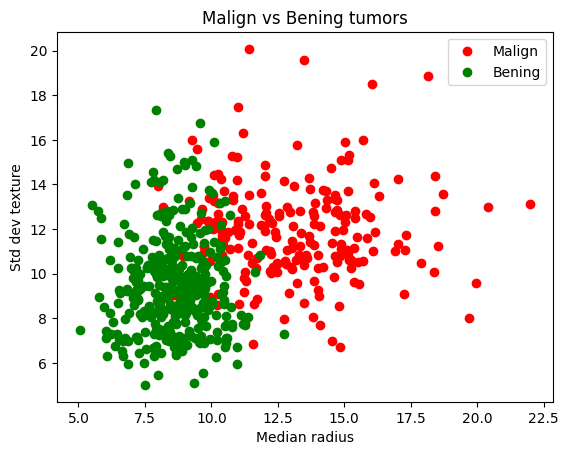

In [11]:
median_radius = [(x + y + z) / 3 for (x,y,z) in zip(X['radius1'], X['radius2'], X['radius3'])]
std_texture = [np.std([x, y, z]) for (x, y, z) in zip(X['texture1'], X['texture2'], X['texture3'])]

median_radius = list(median_radius)
std_texture = list(std_texture)
y = y.values

plot(title='Malign vs Bening tumors', 
     x1=[median_radius[i] for i in range(len(y)) if y[i] == 'M'], 
     y1=[std_texture[i] for i in range(len(y)) if y[i] == 'M'], 
     label1='Malign',
     x2=[median_radius[i] for i in range(len(y)) if y[i] == 'B'], 
     y2=[std_texture[i] for i in range(len(y)) if y[i] == 'B'], 
     label2='Bening', 
     title1='Median radius', 
     title2='Std dev texture', 
     mode1='ro', mode2='go')



# Train test split

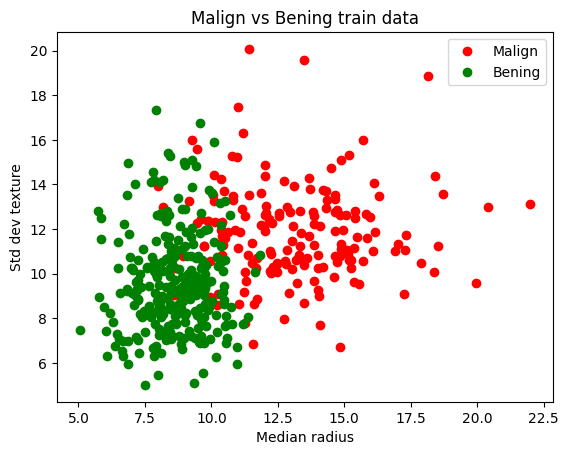

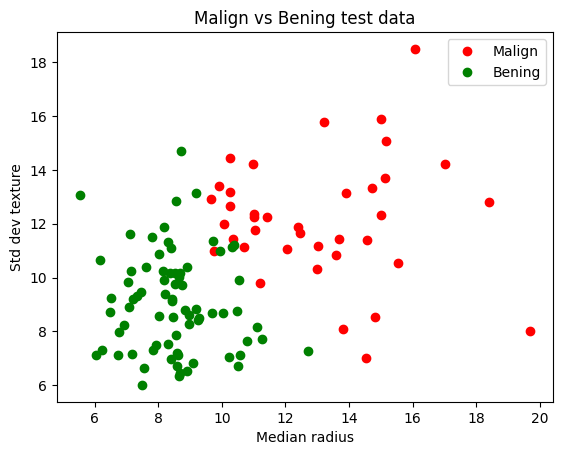

In [13]:
median_radius_df = pd.Series(median_radius, name='median_radius')
std_texture_df = pd.Series(std_texture, name='std_texture')
data_df = pd.concat([median_radius_df, std_texture_df], axis=1)


x_train, x_test, y_train, y_test = train_test_split(data_df, y, test_size=0.2)

def plot_data(x, y, title):
    median_radius_train, std_texture_train = zip(*x[['median_radius', 'std_texture']].values)
    
    plot(title=title, 
         x1=[median_radius_train[i] for i in range(len(y)) if y[i] == 'M'], 
         y1=[std_texture_train[i] for i in range(len(y)) if y[i] == 'M'], 
         label1='Malign',
         x2=[median_radius_train[i] for i in range(len(y)) if y[i] == 'B'], 
         y2=[std_texture_train[i] for i in range(len(y)) if y[i] == 'B'], 
         label2='Bening', 
         title1='Median radius', 
         title2='Std dev texture', 
         mode1='ro', mode2='go')
    
plot_data(x_train, y_train, 'Malign vs Bening train data')
plot_data(x_test, y_test, 'Malign vs Bening test data')

# Data normalisation

In [15]:
x_train_norm, x_test_norm, min_max_list = normalisation(x_train, x_test)

# Model training

In [46]:
y_train = np.array(y_train)
model = LogisticRegression()
model.fit(x_train_norm, y_train)

w0 = model.intercept
w1 = model.coef[0]
w2 = model.coef[1]

median_radius_train, std_texture_train = zip(*x_train_norm)
median_radius_train = np.array(median_radius_train)
std_texture_train = np.array(std_texture_train)

# Predicted vs Actual

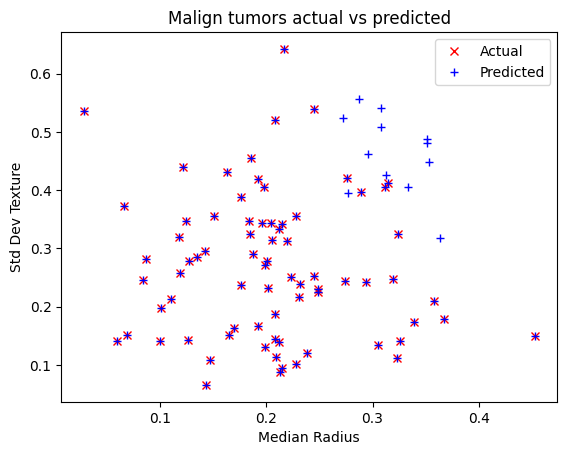

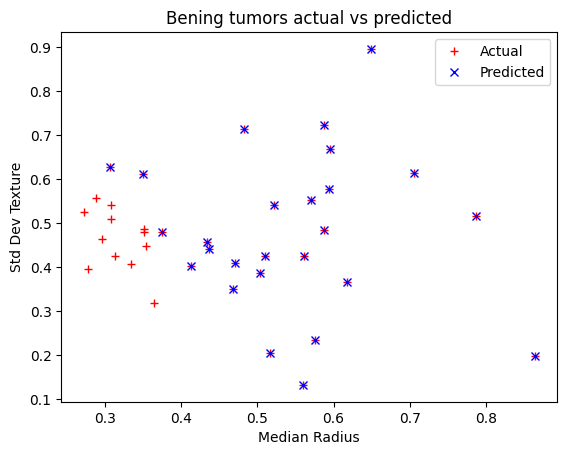

In [52]:
y_predict = model.predict(x_test_norm)

median_radius_test, std_texture_test = zip(*x_test_norm)

median_radius_test = np.array(median_radius_test)
std_texture_test = np.array(std_texture_test)
y_test = np.array(y_test)

y_test_mapped = np.array([1 if label == 'B' else 0 for label in y_test])
y_predict_mapped = np.array([1 if label else 0 for label in y_predict])

plot(title='Malign tumors actual vs predicted',
    x1=median_radius_test[y_test_mapped == 1],
    y1=std_texture_test[y_test_mapped == 1],
    label1='Actual',
    x2=median_radius_test[y_predict_mapped == 1],
    y2=std_texture_test[y_predict_mapped == 1],
    label2='Predicted',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='rx',
    mode2='b+')

plot(title='Bening tumors actual vs predicted',
    x1=median_radius_test[y_test_mapped == 0],
    y1=std_texture_test[y_test_mapped == 0],
    label1='Actual',
    x2=median_radius_test[y_predict_mapped == 0],
    y2=std_texture_test[y_predict_mapped == 0],
    label2='Predicted',
    title1='Median Radius',
    title2='Std Dev Texture',
    mode1='r+',
    mode2='bx')

# Texture = 10, radius = 18

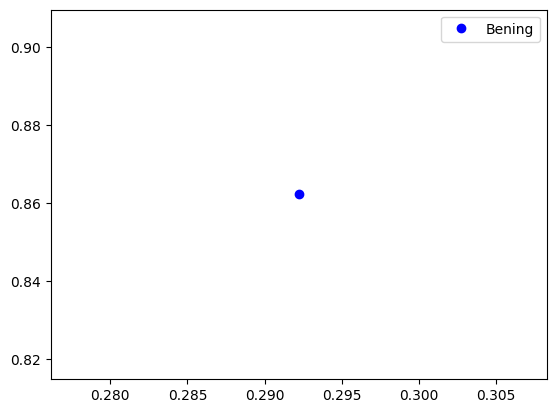

In [39]:
new_x_test = [[10, 18]]
texture_min_max, radius_min_max = min_max_list[0], min_max_list[1]

normalised_new_x_test = [[(x[0] - texture_min_max[0])/ (texture_min_max[1] - texture_min_max[0]),
                          (x[1] - radius_min_max[0]) / (radius_min_max[1] - radius_min_max[0])] for x in new_x_test ]

new_y_test = model.predict(normalised_new_x_test)

label_str = 'Bening'
if new_y_test == 1:
    label_str = 'Malign'

plt.plot(normalised_new_x_test[0][0], normalised_new_x_test[0][1], 'bo', label=label_str)
plt.legend()
